In [101]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sn
from os import listdir, walk, getcwd
from os.path import isfile, join, sep
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage.io import imread, imshow
from skimage.feature import hog
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

# import resizing snippets
from old_conversion import *

In [3]:
filename = "data/Chest_xray_Corona_Metadata.csv"
meta_df = pd.read_csv(filename, header=0)
meta_df.head(10)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
5,5,IM-0117-0001.jpeg,Normal,TRAIN,NaN,NaN
6,6,IM-0115-0001.jpeg,Normal,TRAIN,NaN,NaN
7,7,IM-0189-0001.jpeg,Normal,TRAIN,NaN,NaN
8,8,IM-0187-0001.jpeg,Normal,TRAIN,NaN,NaN
9,9,IM-0185-0001.jpeg,Normal,TRAIN,NaN,NaN


In [4]:
# create dict mapping image names to labels
label_dict = dict()
lim = 10
i = 0
for i, row in meta_df.iterrows():
    label_dict[row.X_ray_image_name] = [row.Label, row.Label_2_Virus_category, row.Label_1_Virus_category]
CLASS_NAMES = meta_df.Label.unique()

In [5]:
def collect_files(path, subpaths):
    f=[]
    l=[]
    i=0
    for subpath in subpaths:
        for (dirpath, dirnames, filenames) in walk("{}/{}".format(path,subpath)):
            for file in filenames:
                f.append("{}/{}/{}".format(path,subpath,file))
                l.append(label_dict[file][0])
            break
    return f,l

In [6]:
path="data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"

pil_path = '\\'.join(path.split('/'))
train_path, train_dest, test_path, test_dest = get_target_paths(pil_path)
check_target_paths([train_dest, test_dest], CLASS_NAMES)

# RESIZE_BOOL = False # For the CNN pipeline, we don't need to resize images

RESIZE_BOOL = True  # For the HOG/SVM pipeline, we want to resize

# ROWS = int(df_sizes.n_rows.mean())
# COLS = int(df_sizes.n_cols.mean
           
ROWS = 300 
COLS = 300 

# convert test set to dimension row by columns
convert_image(test_path,test_dest,ROWS,COLS,label_dict,resize_bool=RESIZE_BOOL)

# convert training set to dimension row by columns
convert_image(train_path,train_dest,ROWS,COLS,label_dict,print_every=500,resize_bool=RESIZE_BOOL) # reduce verbosity

-> Verified target path: data\Coronahack-Chest-XRay-Dataset\Coronahack-Chest-XRay-Dataset\train_modified\Normal
-> Verified target path: data\Coronahack-Chest-XRay-Dataset\Coronahack-Chest-XRay-Dataset\train_modified\Pnemonia
-> Verified target path: data\Coronahack-Chest-XRay-Dataset\Coronahack-Chest-XRay-Dataset\test_modified\Normal
-> Verified target path: data\Coronahack-Chest-XRay-Dataset\Coronahack-Chest-XRay-Dataset\test_modified\Pnemonia
--- Resize images in data\Coronahack-Chest-XRay-Dataset\Coronahack-Chest-XRay-Dataset\test. Store outputs in data\Coronahack-Chest-XRay-Dataset\Coronahack-Chest-XRay-Dataset\test_modified ---
-> 100 files processed out of 624 files.
-> 200 files processed out of 624 files.
-> 300 files processed out of 624 files.
-> 400 files processed out of 624 files.
-> 500 files processed out of 624 files.
-> 600 files processed out of 624 files.

-> Your images are resized at 300 by 300 and are in the path data\Coronahack-Chest-XRay-Dataset\Coronahack-Ches

In [7]:
def shape_rgb_or_grey(img):
    """
    : Report whether img is RGB or greyscale
    """
    shp = img.shape
    color = "RGB" if len(shp) == 3 else "GREY"
    return [shp[0], shp[1], color] 

def summarize_images(f,meta_df):
    '''
    : Summarize the images contained in file hierarchy (f)
    '''
    datasplit_list=[]
    row_nums=[]
    col_nums=[]
    aspect_ratios=[]
    name_short=[]
    labels_list=[]
    file_type=[]
    color_list=[]
    bad_images=[]
    print("--- Parsing {} images ---".format(len(f)))
    print_every = 500
    i = 0

    for filename in f:
        file_short = filename.split("/")[-1]
        file_ext = filename.split(".")[-1]
        if ( file_ext in ["jpeg","jpg","png"]):
            if (i % print_every == 0):
                print("-> {} images parsed".format(i))
            img = imread(filename)
            try:
                data_split = meta_df[meta_df.X_ray_image_name == file_short].Dataset_type.values[0]
                data_label = meta_df[meta_df.X_ray_image_name == file_short].Label.values[0]
                datasplit_list.append(data_split)
                rows, cols, color = shape_rgb_or_grey(img)
                row_nums.append(rows)
                col_nums.append(cols)
                aspect_ratios.append(cols/rows)
                name_short.append(filename.split("/")[-1])
                labels_list.append(data_label)
                file_type.append(file_ext)
                color_list.append(color)
                i += 1
            except ValueError:
                print(ValueError)
                print("{} - shape = {}".format(filename, img.shape))
            except IndexError:
                bad_images.append(file_short)
                print(f'--> {file_short} is not in metadata. Skipping.')
            except:
                print("Unexpected error:", sys.exc_info()[0])
                print(file_short)
                raise

        else:
            print("Skipping {}.".format(filename))

    # summarize image sizes
    data = {"name": name_short, "dataset_type": datasplit_list, "ext": file_type, "color": color_list, "label": labels_list, "n_rows": row_nums, "n_cols": col_nums, "asp_ratio": aspect_ratios}
    df_sizes = pd.DataFrame(data=data,columns=["name", "dataset_type", "ext", "color", "label", "n_rows", "n_cols", "asp_ratio"])
    print(f"--- There were {len(bad_images)} images not included in the metadata .csv ---")
    return [df_sizes, bad_images]


# visualize distribution of image sizes
def df_size_plots(df_sizes):
    fig, axs = plt.subplots(1,2,figsize=(10,3))
    # img size distribution
    hist2d = axs[0].hist2d(df_sizes["n_rows"],df_sizes["n_cols"],bins=50, cmap=plt.cm.jet)
    plt.colorbar(hist2d[3],ax=axs[0])
    axs[0].set_title("Image Size Distribution")
    axs[0].set_xlabel("# Rows")
    axs[0].set_ylabel("# Cols")
    # rgb/color distribution
    colors = ["RGB","GREY"]
    vals = [df_sizes[df_sizes["color"]==color].shape[0] for color in colors]
    axs[1].bar(colors,vals)
    axs[1].set_title("Image Color Distribution")
    axs[1].set_ylabel("Count")
    plt.show()

--- Parsing 5910 images ---
-> 0 images parsed
-> 500 images parsed
-> 1000 images parsed
-> 1500 images parsed
-> 2000 images parsed
-> 2500 images parsed
-> 3000 images parsed
-> 3500 images parsed
-> 4000 images parsed
-> 4500 images parsed
-> 5000 images parsed
-> 5500 images parsed
--- There were 0 images not included in the metadata .csv ---


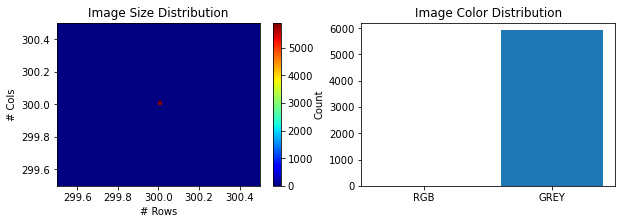

In [34]:
path="data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
subpaths=["test_modified/Normal","test_modified/Pnemonia","train_modified/Normal","train_modified/Pnemonia"]
f,f_label = collect_files(path, subpaths)
df_sizes, bad_images = summarize_images(f, meta_df)
df_sizes.describe()
df_size_plots(df_sizes)

In [9]:
def hog_descriptor(f_paths,image = False): 
    """
    f_path: path of crawled images
    image: set to True to capture hod image array for ALL images,
           set to a list to capature only the indexes in the list
    """
    hog_fd = []
    img_dict = {}
    i = 0
    print_every = 500
        
    for filename in f_paths:
        file_ext = filename.split(".")[-1]
        if ( file_ext in ["jpeg","jpg","png"]):
            if (i % print_every == 0):
                print("-> {} images parsed".format(i))
    
            img = imread(filename)
            try:
                if ((image == True) or (i in image)):
                    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2),  transform_sqrt=True, block_norm="L1", visualize=True)
                    hog_fd.append(fd)
                    img_dict[i]= hog_image                
                else:
                    fd = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2),  transform_sqrt= True, block_norm="L1")
                    hog_fd.append(fd)

                
                i += 1
            except ValueError:
                print(ValueError)
                print("{} - shape = {}".format(filename, img.shape))
            except:
                print("Unknown exception occurred.") 
            
        else:
            print("Skipping {}.".format(filename))
            
    return(hog_fd, img_dict)

In [10]:
subpaths=["train_modified/Normal","train_modified/Pnemonia"]
f_train,label_train = collect_files(path, subpaths)

#create hog decriptions for modified training set
hog_train, img_train = hog_descriptor(f_train,[1,2,3]) 

-> 0 images parsed
-> 500 images parsed
-> 1000 images parsed
-> 1500 images parsed
-> 2000 images parsed
-> 2500 images parsed
-> 3000 images parsed
-> 3500 images parsed
-> 4000 images parsed
-> 4500 images parsed
-> 5000 images parsed


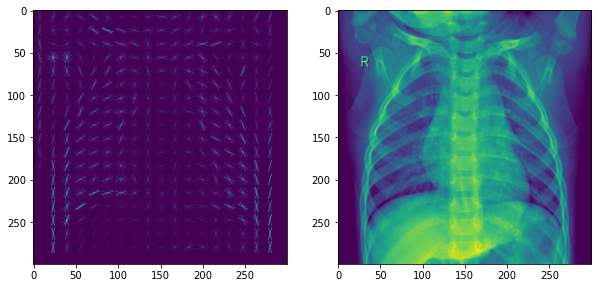

In [128]:
ex_img_train = imread(f_train[2])
fig, ax= plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img_train[2]/img_train[2].max()) 
ax[1].imshow(ex_img_train)

In [14]:
subpaths=["test_modified/Normal","test_modified/Pnemonia"]
f_test, label_test = collect_files(path, subpaths)

#create hog decriptions for modified test set
hog_test, img_test = hog_descriptor(f_test, [2,3])

-> 0 images parsed
-> 500 images parsed


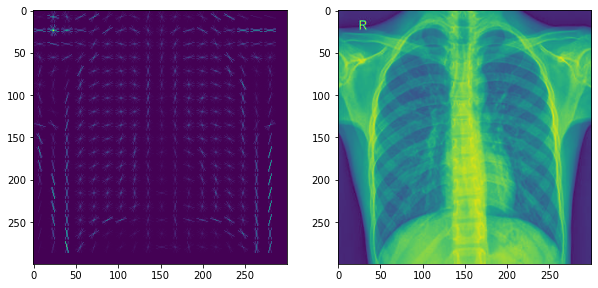

In [127]:
ex_img_test = imread(f_test[2])
fig, ax= plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img_test[2]/img_test[2].max()) 
ax[1].imshow(ex_img_test)
# imshow(img_test[2]/img_test[2].max()) 

In [16]:
def data_stack(hog_fd,label):
    label =  np.array(label).reshape(len(label),1)
    hog_fd = np.array(hog_fd)
    
    data_array = np.hstack((hog_fd,label))
    
    x = data_array[:,:-1]
    y = data_array[:,-1:].ravel()
    
    return (x,y)

In [49]:
# x_train,y_train = data_stack(hog_train,label_train)
x_test,y_test = data_stack(hog_test,label_test)

In [20]:
# param_grid = {'C': [0.1,1, 10], 'gamma': [1,0.1,0.01],'kernel': ['linear','rbf', 'poly']}
# model = GridSearchCV(SVC(),param_grid,refit=True,verbose=2, n_jobs = -1)

In [25]:
model = make_pipeline(StandardScaler(), SVC(C=1, gamma=0.1, kernel='poly',probability = True,random_state = 7))
model.fit(x_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=1, gamma=0.1, kernel='poly', probability=True,
                     random_state=7))])

In [59]:
predictions_probs = model.predict_proba(x_test)
predictions = model.predict(x_test)

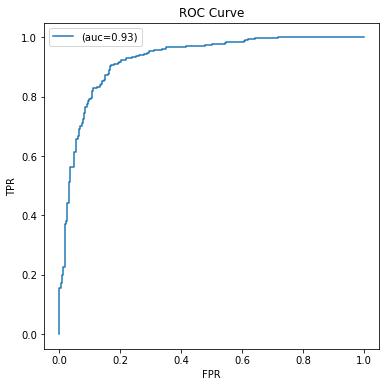

In [92]:
fpr_dur, tpr_dur,_ = metrics.roc_curve(y_test,predictions_probs[:,1] ,pos_label='Pnemonia')
auc = metrics.roc_auc_score(y_test,predictions_probs[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr_dur,tpr_dur,label='(auc={:3.2f})'.format(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC Curve")
plt.legend()

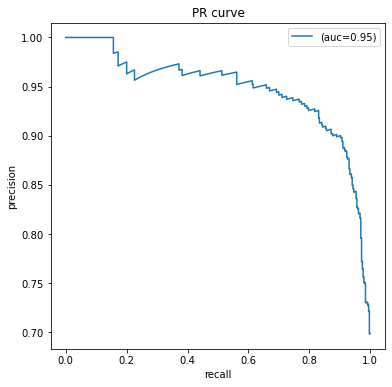

In [93]:
prec_nn, rec_nn, threshs = metrics.precision_recall_curve(y_test,predictions_probs[:,1],pos_label='Pnemonia')
auc = metrics.auc(rec_nn, prec_nn)
plt.figure(figsize=(6,6))
plt.plot(rec_nn,prec_nn,label='(auc={:3.2f})'.format(auc))
plt.xlabel('recall')
plt.ylabel('precision')
plt.title("PR curve")
plt.legend()

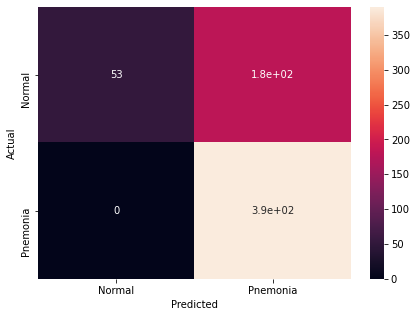

In [104]:
data = {"y_test": y_test, "y_hat":predictions}
df = pd.DataFrame(data, columns=["y_test", "y_hat"])
confusion_matrix = pd.crosstab(df['y_test'],df['y_hat'],rownames=["Actual"],colnames=['Predicted'])
f, ax = plt.subplots(figsize=(7,5))
sn.heatmap(confusion_matrix, annot=True)
plt.show()